# Trousers and jeans model

# Import relevant libraries

In [1]:
import io
import itertools
import numpy as np
import sklearn.metrics
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
import matplotlib.pyplot as plt

# Load the data

Data train files: ['images', 'labels']
Size of the images: (2002, 120, 90, 3)
Size of the labels: (2002,)
Unique values of the labels: [0 1]
The label of 873'th image is 0
The label of 1344'th image is 0


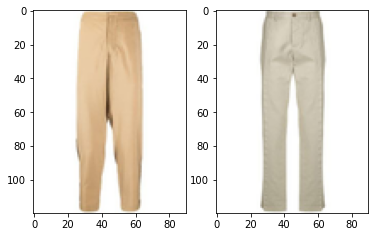

In [2]:
data_train = np.load(r"data/Trousers & Jeans - Male - Train.npz")
data_validation = np.load(r"data/Trousers & Jeans - Male - Validation.npz")
data_test = np.load(r"data/Trousers & Jeans - Male - Test.npz")

print("Data train files: {}".format(data_train.files))
print("Size of the images: {}".format(data_train['images'].shape))
print("Size of the labels: {}".format(data_train['labels'].shape))
print("Unique values of the labels: {}".format(np.unique(data_train['labels'])))
n = np.random.randint(0, 2002)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(data_train['images'][n])
print("The label of {}'th image is {}".format(n, data_train['labels'][n]))

n = np.random.randint(0, 2002)
ax2.imshow(data_train['images'][n])
print("The label of {}'th image is {}".format(n, data_train['labels'][n]))

In [3]:
images_train = data_train['images']
labels_train = data_train['labels']

images_val = data_validation['images']
labels_val = data_validation['labels']

images_test = data_test['images']
labels_test = data_test['labels']

In [4]:
images_train = images_train/255.0
images_val = images_val/255.0
images_test = images_test/255.0 

# Training the models

In [5]:
EPOCHS = 15
BATCH_SIZE = 64 #power of 2

HP_FILTER_SIZE_1 = hp.HParam('filter_size_1', hp.Discrete([3,5,7]))
HP_FILTER_NUM = hp.HParam('filters_number', hp.Discrete([32,64]))
HP_FILTER_SIZE_2 = hp.HParam('filter_size_2', hp.Discrete([3,5]))
HP_DENSE_SIZE = hp.HParam('dense_size', hp.Discrete([256,512]))

METRIC_ACCURACY = "accuracy"

with tf.summary.create_file_writer(r'Logs/Model 4_2/hparam_tuning/').as_default():
    hp.hparams_config(
        hparams=[HP_FILTER_SIZE_1, HP_FILTER_NUM, HP_FILTER_SIZE_2, HP_DENSE_SIZE],
        metrics=[hp.Metric(METRIC_ACCURACY, display_name='Accuracy')],
    )

In [6]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)

    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

In [7]:
def plot_to_image(figure):
    """Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call."""
    # Save the plot to a PNG in memory.
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    # Convert PNG buffer to TF image
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    # Add the batch dimension
    image = tf.expand_dims(image, 0)
    return image

In [8]:
def train_test_model(hparams, session_num):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(
            hparams[HP_FILTER_NUM], 
            hparams[HP_FILTER_SIZE_1], 
            activation='relu',
            input_shape=(120,90,3)),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Conv2D(
            hparams[HP_FILTER_NUM], 
            hparams[HP_FILTER_SIZE_2], 
            activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hparams[HP_DENSE_SIZE], activation='relu'),
        tf.keras.layers.Dense(2)
    ])
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    model.compile(optimizer="adam", loss=loss_fn, metrics=['accuracy'])
    

    log_dir = "Logs\\Model 4_2\\fit\\" + "run {}".format(session_num)
    
  
    file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
    
    def log_confusion_matrix(epoch, logs):
        
        test_pred_raw = model.predict(images_val)
        test_pred = np.argmax(test_pred_raw, axis=1)

        
        cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)
       
        figure = plot_confusion_matrix(cm, class_names=['Trousers', 'Jeans'])
        cm_image = plot_to_image(figure)

        
        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
    
    
    
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch=0)
    cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)
    

    
 
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss',
        mode = 'auto',
        min_delta = 0,
        patience = 2,
        verbose = 0, 
        restore_best_weights = True
    )
    

    model.fit(
        images_train,
        labels_train,
        epochs = EPOCHS,
        batch_size = BATCH_SIZE,
        callbacks = [tensorboard_callback, cm_callback, early_stopping],
        validation_data = (images_val,labels_val),
        verbose = 2
    )
    
    

    _, accuracy = model.evaluate(images_val,labels_val)
    

    model.save(r"saved_models\Model 4_2\Run-{}".format(session_num))
    
    return accuracy

In [9]:
def run(log_dir, hparams, session_num):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)
        accuracy = train_test_model(hparams, session_num)
        tf.summary.scalar(METRIC_ACCURACY, accuracy, step = 1)

In [10]:
session_num = 1

for filter_size_1 in HP_FILTER_SIZE_1.domain.values:
    for filter_num in HP_FILTER_NUM.domain.values:
        for filter_size_2 in HP_FILTER_SIZE_2.domain.values:
            for dense_size in HP_DENSE_SIZE.domain.values:

                    hparams = {
                        HP_FILTER_SIZE_1: filter_size_1,
                        HP_FILTER_NUM: filter_num,
                        HP_FILTER_SIZE_2: filter_size_2,
                        HP_DENSE_SIZE: dense_size
                    }

                    run_name = "run-%d" % session_num
                    print('--- Starting trial: %s' % run_name)
                    print({h.name: hparams[h] for h in hparams})
                    run('Logs/Model 4_2/hparam_tuning/' + run_name, hparams, session_num)

                    session_num += 1

--- Starting trial: run-1
{'filter_size_1': 3, 'filters_number': 32, 'filter_size_2': 3, 'dense_size': 256}
Epoch 1/15
32/32 - 5s - loss: 0.9504 - accuracy: 0.6334 - val_loss: 0.5120 - val_accuracy: 0.7480
Epoch 2/15
32/32 - 5s - loss: 0.4635 - accuracy: 0.7832 - val_loss: 0.4328 - val_accuracy: 0.7880
Epoch 3/15
32/32 - 5s - loss: 0.4100 - accuracy: 0.8202 - val_loss: 0.4216 - val_accuracy: 0.8200
Epoch 4/15
32/32 - 5s - loss: 0.3558 - accuracy: 0.8432 - val_loss: 0.3801 - val_accuracy: 0.8120
Epoch 5/15
32/32 - 5s - loss: 0.3531 - accuracy: 0.8392 - val_loss: 0.3439 - val_accuracy: 0.8440
Epoch 6/15
32/32 - 5s - loss: 0.2998 - accuracy: 0.8681 - val_loss: 0.3145 - val_accuracy: 0.8600
Epoch 7/15
32/32 - 5s - loss: 0.2677 - accuracy: 0.8776 - val_loss: 0.3674 - val_accuracy: 0.8480
Epoch 8/15
32/32 - 8s - loss: 0.2817 - accuracy: 0.8751 - val_loss: 0.3309 - val_accuracy: 0.8520
8/8 [==============================] - 0s 20ms/step - loss: 0.3145 - accuracy: 0.8600
INFO:tensorflow:Assets

Epoch 6/15
32/32 - 29s - loss: 0.3360 - accuracy: 0.8452 - val_loss: 0.3485 - val_accuracy: 0.8600
Epoch 7/15
32/32 - 29s - loss: 0.3175 - accuracy: 0.8472 - val_loss: 0.3304 - val_accuracy: 0.8600
Epoch 8/15
32/32 - 28s - loss: 0.2950 - accuracy: 0.8671 - val_loss: 0.4129 - val_accuracy: 0.8080
Epoch 9/15
32/32 - 31s - loss: 0.2945 - accuracy: 0.8606 - val_loss: 0.5107 - val_accuracy: 0.8240
8/8 [==============================] - 0s 51ms/step - loss: 0.3304 - accuracy: 0.8600
INFO:tensorflow:Assets written to: saved_models\Model 4_2\Run-7\assets
--- Starting trial: run-8
{'filter_size_1': 3, 'filters_number': 64, 'filter_size_2': 5, 'dense_size': 512}
Epoch 1/15
32/32 - 33s - loss: 1.2900 - accuracy: 0.6474 - val_loss: 0.4896 - val_accuracy: 0.7720
Epoch 2/15
32/32 - 33s - loss: 0.4712 - accuracy: 0.7802 - val_loss: 0.4711 - val_accuracy: 0.7960
Epoch 3/15
32/32 - 32s - loss: 0.4089 - accuracy: 0.8237 - val_loss: 0.3606 - val_accuracy: 0.8400
Epoch 4/15
32/32 - 30s - loss: 0.3379 - ac

Epoch 5/15
32/32 - 27s - loss: 0.4586 - accuracy: 0.7772 - val_loss: 0.5012 - val_accuracy: 0.7400
8/8 [==============================] - 0s 48ms/step - loss: 0.4588 - accuracy: 0.7760
INFO:tensorflow:Assets written to: saved_models\Model 4_2\Run-15\assets
--- Starting trial: run-16
{'filter_size_1': 5, 'filters_number': 64, 'filter_size_2': 5, 'dense_size': 512}
Epoch 1/15
32/32 - 32s - loss: 1.0370 - accuracy: 0.6189 - val_loss: 0.5097 - val_accuracy: 0.7720
Epoch 2/15
32/32 - 32s - loss: 0.4692 - accuracy: 0.7847 - val_loss: 0.4302 - val_accuracy: 0.7960
Epoch 3/15
32/32 - 32s - loss: 0.4139 - accuracy: 0.8142 - val_loss: 0.4499 - val_accuracy: 0.7840
Epoch 4/15
32/32 - 32s - loss: 0.3975 - accuracy: 0.8227 - val_loss: 0.3987 - val_accuracy: 0.8360
Epoch 5/15
32/32 - 32s - loss: 0.3444 - accuracy: 0.8487 - val_loss: 0.3948 - val_accuracy: 0.8440
Epoch 6/15
32/32 - 32s - loss: 0.3174 - accuracy: 0.8531 - val_loss: 0.3352 - val_accuracy: 0.8760
Epoch 7/15
32/32 - 33s - loss: 0.2903 - 

Epoch 4/15
32/32 - 38s - loss: 0.4847 - accuracy: 0.7602 - val_loss: 0.4444 - val_accuracy: 0.7760
Epoch 5/15
32/32 - 38s - loss: 0.4312 - accuracy: 0.7887 - val_loss: 0.4015 - val_accuracy: 0.8120
Epoch 6/15
32/32 - 38s - loss: 0.4414 - accuracy: 0.7892 - val_loss: 0.4353 - val_accuracy: 0.7880
Epoch 7/15
32/32 - 38s - loss: 0.4185 - accuracy: 0.7952 - val_loss: 0.3852 - val_accuracy: 0.8120
Epoch 8/15
32/32 - 36s - loss: 0.4191 - accuracy: 0.7992 - val_loss: 0.4453 - val_accuracy: 0.7720
Epoch 9/15
32/32 - 39s - loss: 0.4362 - accuracy: 0.7882 - val_loss: 0.3886 - val_accuracy: 0.7960
8/8 [==============================] - 1s 111ms/step - loss: 0.3852 - accuracy: 0.8120
INFO:tensorflow:Assets written to: saved_models\Model 4_2\Run-24\assets


In [2]:
%load_ext tensorboard
%tensorboard --logdir "Logs/Model 4_2/hparam_tuning"

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
